In [1]:
import os, sys

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', 200)

In [2]:
df = pd.read_csv("Train.csv")
df_test = pd.read_csv("Test.csv")

df.sample(n=10, random_state=1) # random_state provides reproducibility :)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
6087,464509,Male,Yes,53,Yes,Artist,0.0,High,4.0,Cat_6,C
6723,467663,Male,Yes,31,No,Doctor,NaN,Average,2.0,Cat_6,D
130,465215,Male,Yes,39,Yes,Executive,9.0,High,5.0,Cat_2,A
3792,464782,Male,Yes,35,No,Marketing,0.0,Low,3.0,Cat_4,D
4444,465124,Female,Yes,29,Yes,Healthcare,6.0,Average,2.0,Cat_6,A
5685,466623,Male,Yes,56,NaN,Entertainment,4.0,Average,4.0,Cat_3,C
103,463426,Male,Yes,38,No,Executive,0.0,High,5.0,Cat_6,A
3988,460413,Female,No,39,Yes,Artist,7.0,Low,1.0,Cat_6,B
2567,463439,Male,Yes,42,Yes,Artist,9.0,Average,3.0,Cat_6,B
3593,460147,Male,Yes,67,Yes,Entertainment,1.0,Average,3.0,Cat_6,C


# Quick Data Cleaning
We first analyze which columns have null, non-zero value. We try to fill those values first with categorical data based on our judgment.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [4]:
num_rows, num_cols = df.shape
print("Total rows:", num_rows, "\nTotal columns:", num_cols)

Total rows: 8068 
Total columns: 11


In [5]:
# Printing every unique values in our dataset, which involves `object` and `float64` datatype.
for i in df.select_dtypes(include=['object', 'float64']).columns:
    print("Column: ", i)
    print(df[i].unique())
    print()

Column:  Gender
['Male' 'Female']

Column:  Ever_Married
['No' 'Yes' nan]

Column:  Graduated
['No' 'Yes' nan]

Column:  Profession
['Healthcare' 'Engineer' 'Lawyer' 'Entertainment' 'Artist' 'Executive'
 'Doctor' 'Homemaker' 'Marketing' nan]

Column:  Work_Experience
[ 1. nan  0.  4.  9. 12.  3. 13.  5.  8. 14.  7.  2.  6. 10. 11.]

Column:  Spending_Score
['Low' 'Average' 'High']

Column:  Family_Size
[ 4.  3.  1.  2.  6. nan  5.  8.  7.  9.]

Column:  Var_1
['Cat_4' 'Cat_6' 'Cat_7' 'Cat_3' 'Cat_1' 'Cat_2' nan 'Cat_5']

Column:  Segmentation
['D' 'A' 'B' 'C']



In [6]:
# Printing the number of null, non-zero values within each of the variables.
for column in df.columns:
    print(column)
    print (df.isnull()[column].value_counts())
    print("")

ID
False    8068
Name: ID, dtype: int64

Gender
False    8068
Name: Gender, dtype: int64

Ever_Married
False    7928
True      140
Name: Ever_Married, dtype: int64

Age
False    8068
Name: Age, dtype: int64

Graduated
False    7990
True       78
Name: Graduated, dtype: int64

Profession
False    7944
True      124
Name: Profession, dtype: int64

Work_Experience
False    7239
True      829
Name: Work_Experience, dtype: int64

Spending_Score
False    8068
Name: Spending_Score, dtype: int64

Family_Size
False    7733
True      335
Name: Family_Size, dtype: int64

Var_1
False    7992
True       76
Name: Var_1, dtype: int64

Segmentation
False    8068
Name: Segmentation, dtype: int64



Thankfully the only continuous data with missing values are `Family_Size` and `Work_Experience`, thus we can define the data well enough.

## Filling `nan` values towards our missing data with proper considerations:
1. `Ever_Married`: `Rather not disclose`, assuming that the user does not disclose out of privacy. This will create a new category;
2. `Graduated`: `Yes`, referring to the majority of buyers, who will most likely already out of college;
3. `Profession`: `Unemployed`, safest assumption towards datapoints without explicit profession statement. This will create a new category;
4. `Work_Experience`: `0`, since the data is numerical with the lowest point of `1.`, we can assume that `null` work experience translates to the buyer not having any prior work experience;
5. `Family_Size`: `1`, assuming that the buyer is currently single and/or living far away from parents;

We can also drop the column `Var_1` since it represents anonymized user data, and does not represent the actual pattern of datapoints. We separate labels from features.
 

In [7]:
values_to_fill = {
    'Ever_Married': 'Rather not disclose', 
    'Graduated': 'Yes', 
    'Profession': 'Unemployed',
    'Work_Experience': 0,
    'Family_Size': 1
}

cleaned_df = df.fillna(value=values_to_fill).drop('Var_1', axis=1)
cleaned_test_df = df_test.fillna(value=values_to_fill).drop('Var_1', axis=1)
# Sanity check
cleaned_test_df.isnull().values.any()


False

In [8]:
# This fraction has been the exact same 10 samples displayed before cleaning.
cleaned_df.sample(n=10, random_state=1) 

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Segmentation
6087,464509,Male,Yes,53,Yes,Artist,0.0,High,4.0,C
6723,467663,Male,Yes,31,No,Doctor,0.0,Average,2.0,D
130,465215,Male,Yes,39,Yes,Executive,9.0,High,5.0,A
3792,464782,Male,Yes,35,No,Marketing,0.0,Low,3.0,D
4444,465124,Female,Yes,29,Yes,Healthcare,6.0,Average,2.0,A
5685,466623,Male,Yes,56,Yes,Entertainment,4.0,Average,4.0,C
103,463426,Male,Yes,38,No,Executive,0.0,High,5.0,A
3988,460413,Female,No,39,Yes,Artist,7.0,Low,1.0,B
2567,463439,Male,Yes,42,Yes,Artist,9.0,Average,3.0,B
3593,460147,Male,Yes,67,Yes,Entertainment,1.0,Average,3.0,C


In [9]:
for x in cleaned_df.columns:
    print(cleaned_df[x].value_counts())
    print()

460801    1
465542    1
465566    1
459421    1
461468    1
         ..
460050    1
466193    1
464144    1
462091    1
460799    1
Name: ID, Length: 8068, dtype: int64

Male      4417
Female    3651
Name: Gender, dtype: int64

Yes                    4643
No                     3285
Rather not disclose     140
Name: Ever_Married, dtype: int64

35    250
37    234
42    232
33    232
40    229
27    229
43    226
38    221
32    221
28    220
25    218
31    214
36    209
39    208
41    206
26    200
30    196
29    183
50    180
47    167
51    161
46    160
45    158
53    158
52    157
49    155
48    154
22    142
19    134
18    132
23    129
20    127
21    116
56    110
55     98
59     97
60     95
61     93
57     93
62     85
58     80
63     80
65     72
66     72
70     71
68     69
72     67
69     67
67     55
73     54
71     49
81     42
89     36
82     36
88     35
83     35
79     34
84     33
75     32
86     30
74     30
77     30
78     29
87     28
76     27
80  

In [10]:
features = cleaned_df.iloc[:, 1:-1] 
features["Work_Experience_to_Age_Ratio"] = features["Work_Experience"] / features["Age"]

labels = cleaned_df.iloc[:, -1]

features_test = cleaned_test_df.iloc[:, 1:-1] 
features_test["Work_Experience_to_Age_Ratio"] = features_test["Work_Experience"] / features_test["Age"]

labels_test = cleaned_test_df.iloc[:, -1]

features

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Work_Experience_to_Age_Ratio
0,Male,No,22,No,Healthcare,1.0,Low,4.0,0.045455
1,Female,Yes,38,Yes,Engineer,0.0,Average,3.0,0.000000
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,0.014925
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,0.000000
4,Female,Yes,40,Yes,Entertainment,0.0,High,6.0,0.000000
...,...,...,...,...,...,...,...,...,...
8063,Male,No,22,No,Unemployed,0.0,Low,7.0,0.000000
8064,Male,No,35,No,Executive,3.0,Low,4.0,0.085714
8065,Female,No,33,Yes,Healthcare,1.0,Low,1.0,0.030303
8066,Female,No,27,Yes,Healthcare,1.0,Low,4.0,0.037037


In [11]:
labels

0       D
1       A
2       B
3       B
4       A
       ..
8063    D
8064    D
8065    D
8066    B
8067    B
Name: Segmentation, Length: 8068, dtype: object

# Preprocessing
## Label Encoding
Categorical data must be pre-processed using one-hot encoding. In this workflow, we'll use Label Encoding (as opposed to the usual one-hot encoding) so as to save memory by converting categorical variables towards a single dense array without making a new column for each.

We do this by importing the necessities from `sklearn.preprocessing`.

In [12]:
from sklearn.preprocessing import LabelEncoder

## Helper function to map encoded label classes
def get_integer_mapping(le):
    '''
    Return a dict mapping labels to their integer values
    from an SKlearn LabelEncoder

    Arguments:
    le = a fitted SKlearn LabelEncoder
    '''
    res = {}
    for cl in le.classes_:
        res.update({cl:le.transform([cl])[0]})

    return res

## In-place transformation towards features:
for col in ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score']:
    encoder = LabelEncoder()
    features[col] = encoder.fit_transform(features[col])
    print("For column:", col)
    print(get_integer_mapping(encoder))

## We do the same in-place transformation towards test features:
for col in ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score']:
    encoder = LabelEncoder()
    features_test[col] = encoder.fit_transform(features_test[col])
    ## print("For column: ", col)
    ## print(get_integer_mapping(encoder))


For column: Gender
{'Female': 0, 'Male': 1}
For column: Ever_Married
{'No': 0, 'Rather not disclose': 1, 'Yes': 2}
For column: Graduated
{'No': 0, 'Yes': 1}
For column: Profession
{'Artist': 0, 'Doctor': 1, 'Engineer': 2, 'Entertainment': 3, 'Executive': 4, 'Healthcare': 5, 'Homemaker': 6, 'Lawyer': 7, 'Marketing': 8, 'Unemployed': 9}
For column: Spending_Score
{'Average': 0, 'High': 1, 'Low': 2}


## Normalization
The feature `Age` has potential to squish our other features flat when plotting towards one another. Thus, we perform **Normalization** to prevent this from happening. 

We can do this also from the `sklearn.preprocessing` class.

In [13]:
from sklearn.preprocessing import MinMaxScaler
feature_columns = features.columns.tolist()
scaler = MinMaxScaler() # Instantiate scaler object
features['Age'] = scaler.fit_transform(features[['Age']])

features.sample(n=10, random_state=1)

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Work_Experience_to_Age_Ratio
6087,1,2,0.492958,1,0,0.0,1,4.0,0.000000
6723,1,2,0.183099,0,1,0.0,0,2.0,0.000000
130,1,2,0.295775,1,4,9.0,1,5.0,0.230769
3792,1,2,0.239437,0,8,0.0,2,3.0,0.000000
4444,0,2,0.154930,1,5,6.0,0,2.0,0.206897
5685,1,2,0.535211,1,3,4.0,0,4.0,0.071429
103,1,2,0.281690,0,4,0.0,1,5.0,0.000000
3988,0,0,0.295775,1,0,7.0,2,1.0,0.179487
2567,1,2,0.338028,1,0,9.0,0,3.0,0.214286
3593,1,2,0.690141,1,3,1.0,0,3.0,0.014925


# Correlation Heatmap
After the data has been label-encoded, we can then take a quick peek at the correlation between the variables (features) as to how much they relate with one another.

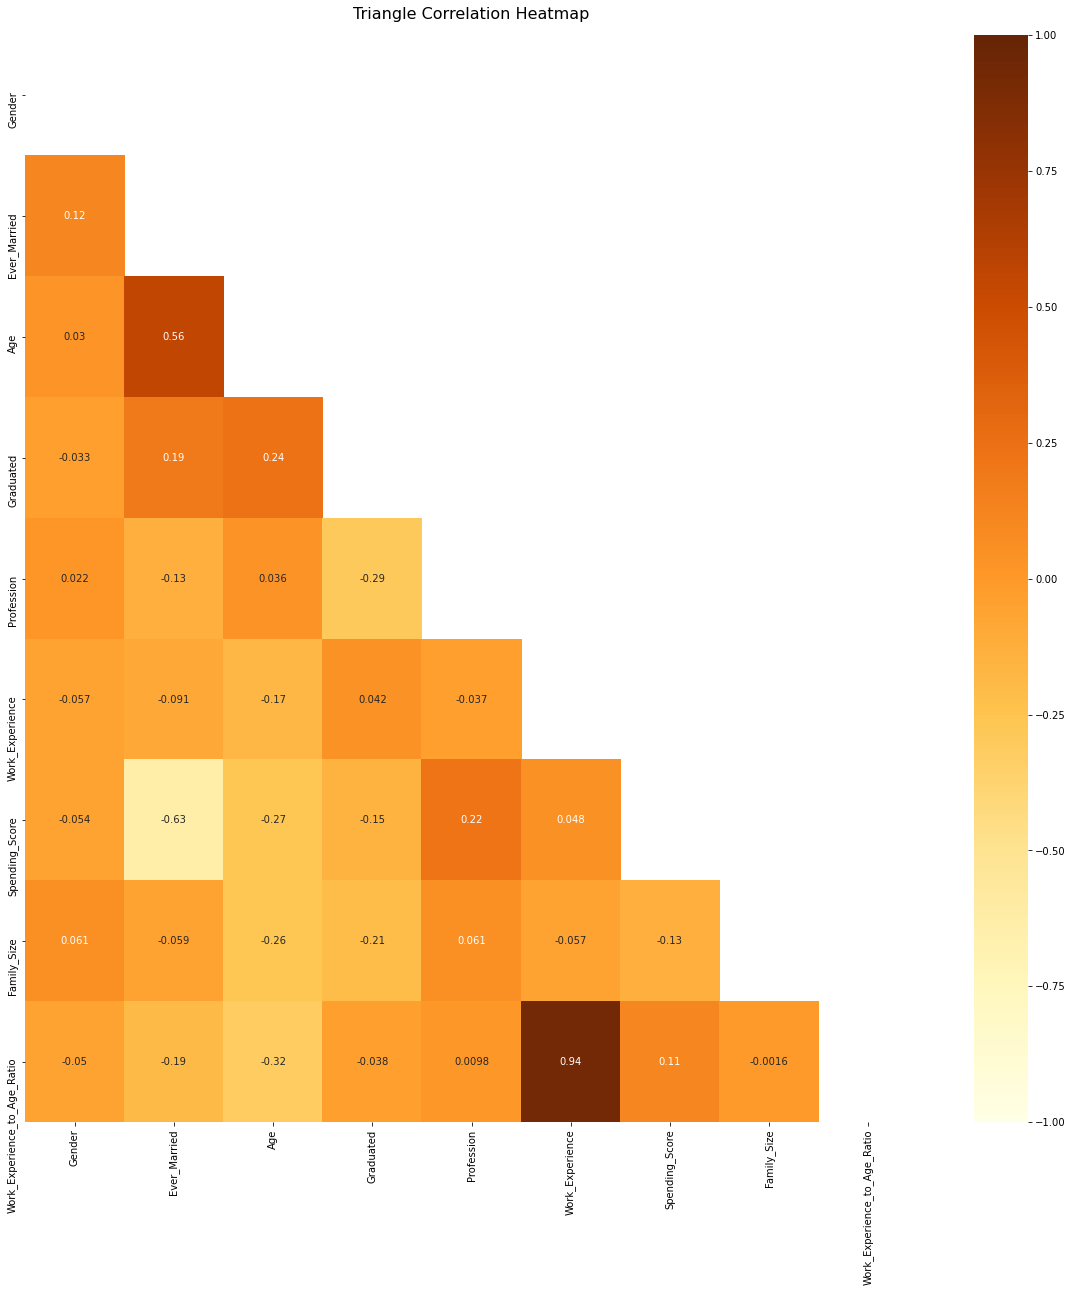

In [14]:
plt.figure(figsize=(20, 20))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(features.corr(), dtype=np.bool))
heatmap = sns.heatmap(features.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("YlOrBr", as_cmap=True))
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':16}, pad=16);
plt.savefig("correlation.png", dpi=400)

D:\SOFTWARE KULIAH\Conda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\SOFTWARE KULIAH\Conda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\SOFTWARE KULIAH\Conda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(

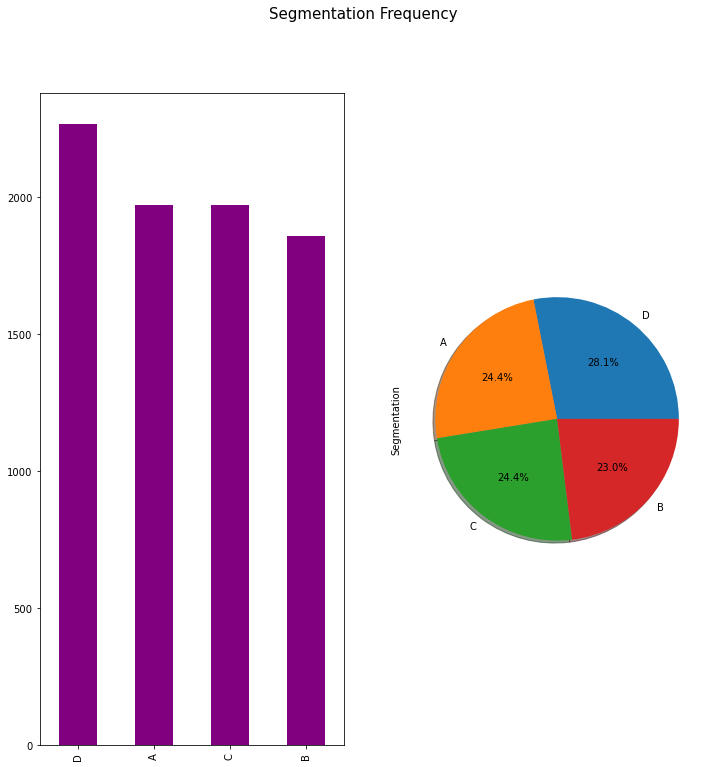

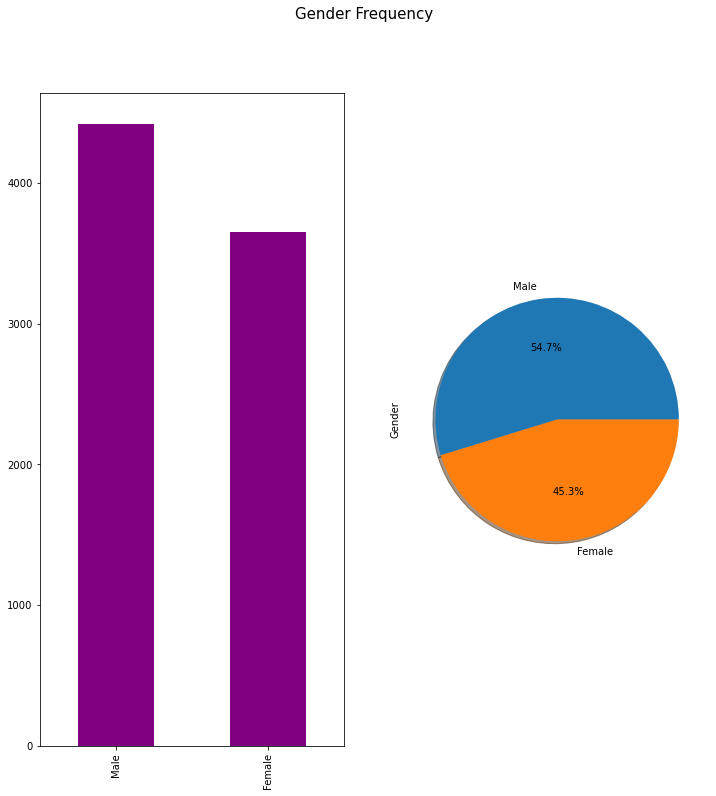

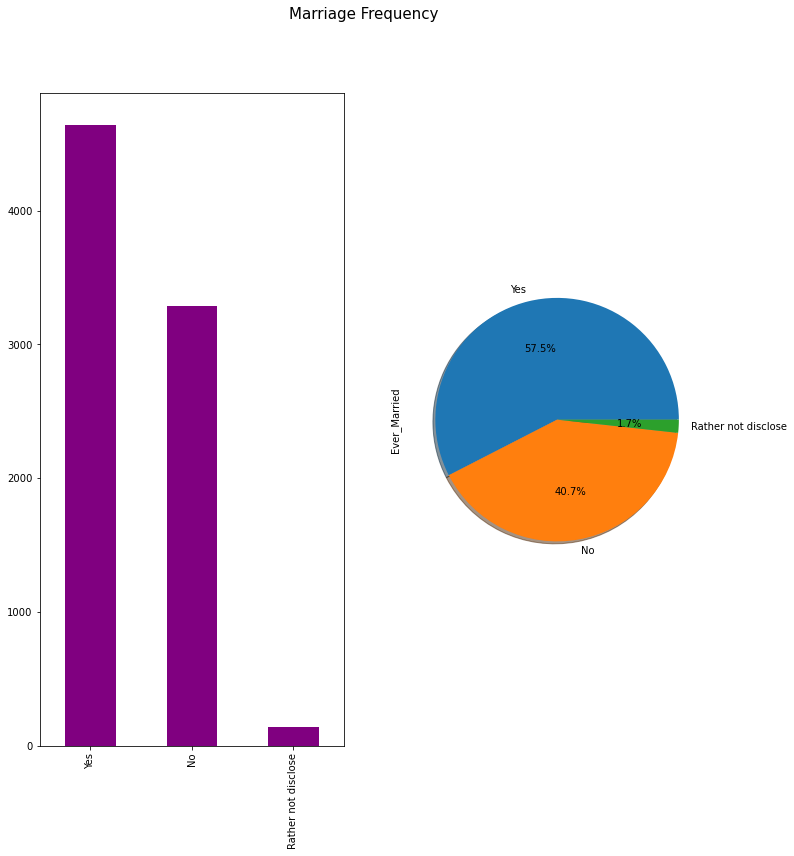

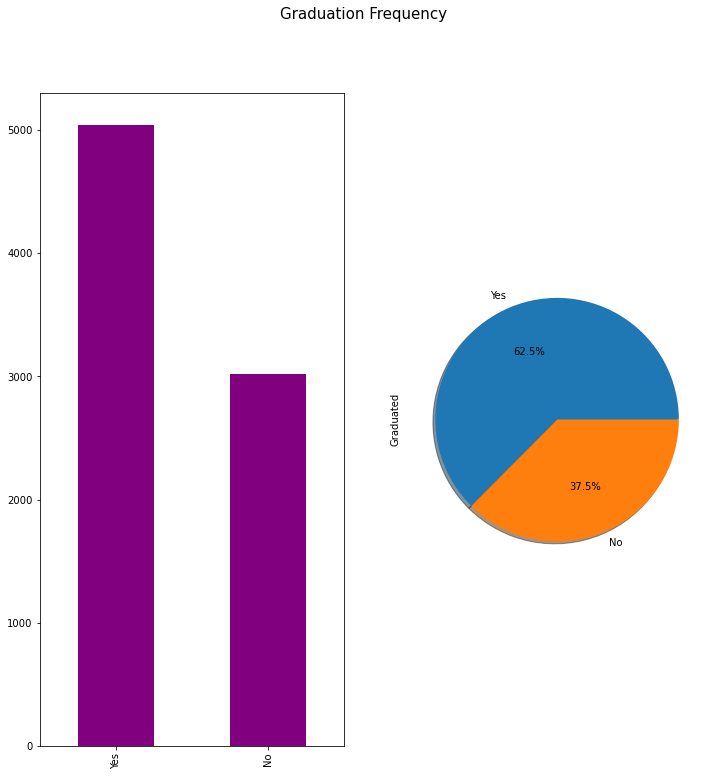

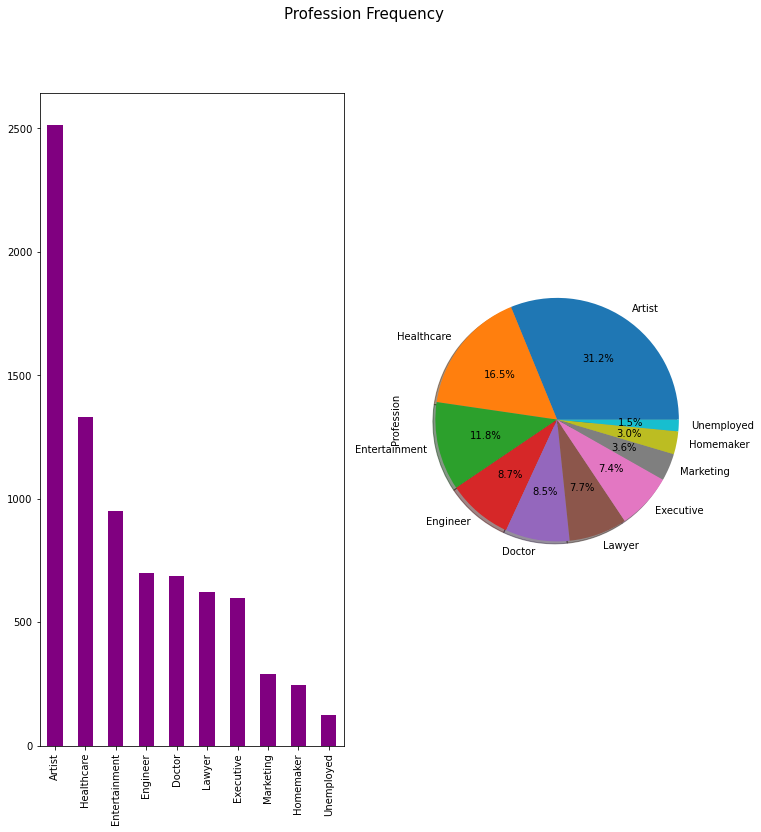

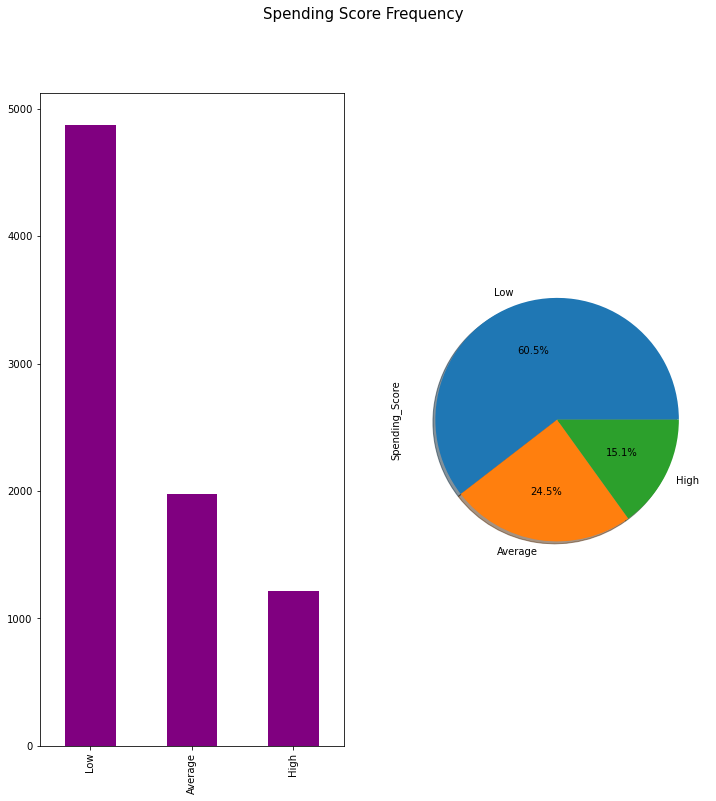

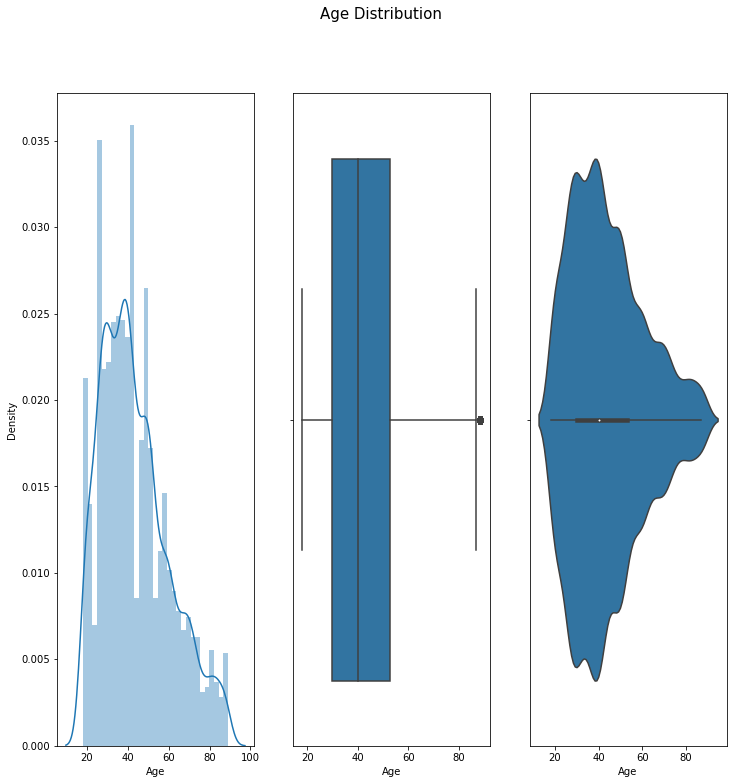

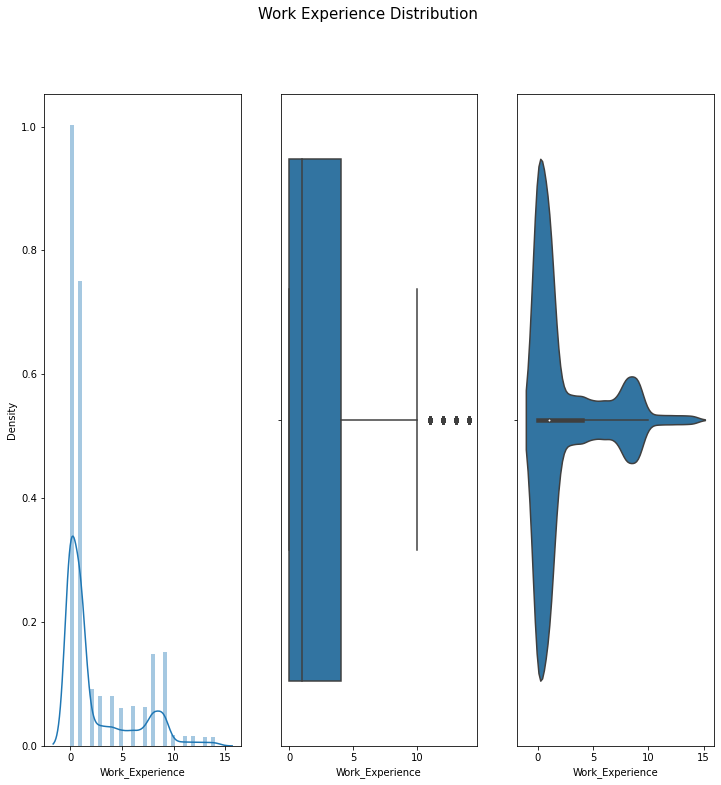

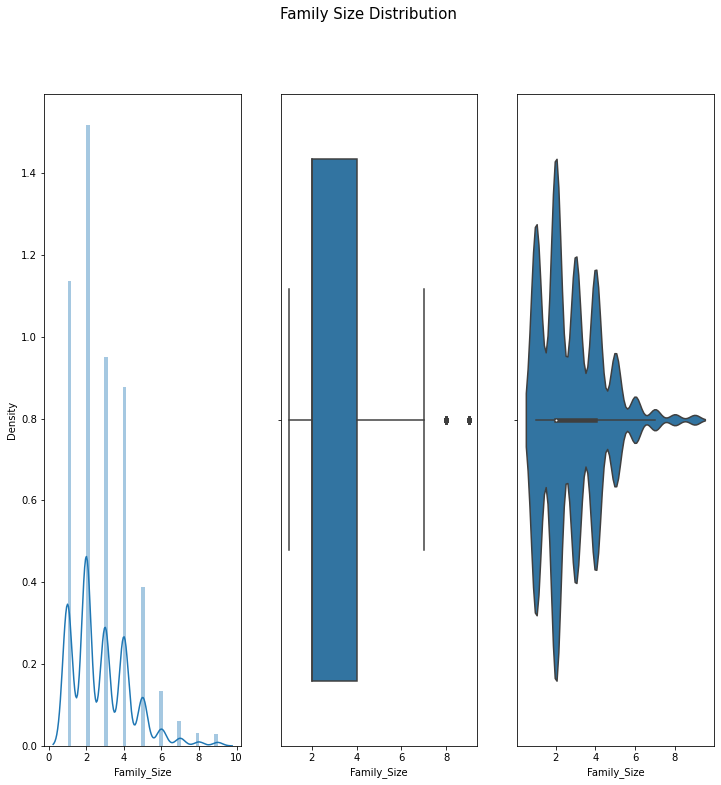

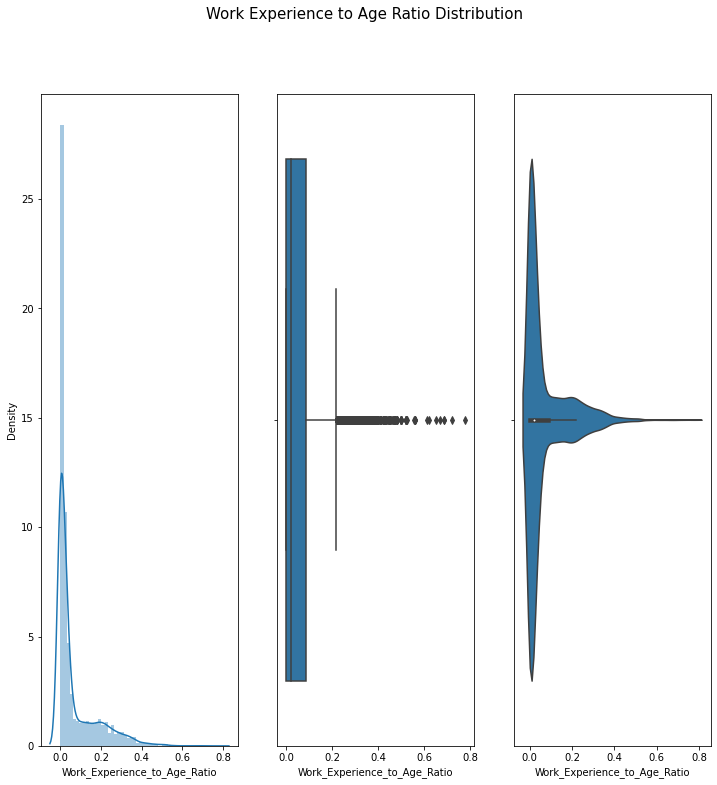

In [15]:
#Plotting Categorical Variables

fig, ax = plt.subplots(1, 2, figsize=(12,12))
cleaned_df["Segmentation"].value_counts().plot.bar(color="purple", ax=ax[0])
cleaned_df["Segmentation"].value_counts().plot.pie(autopct='%1.1f%%',shadow=True,textprops={"fontsize": 10},ax=ax[1])
fig.suptitle("Segmentation Frequency", fontsize=15)
plt.xticks(rotation=90)
plt.yticks(rotation=45)
plt.savefig("Segmentation.png", dpi=350)

fig, ax = plt.subplots(1, 2, figsize=(12,12))
cleaned_df["Gender"].value_counts().plot.bar(color="purple", ax=ax[0])
cleaned_df["Gender"].value_counts().plot.pie(autopct='%1.1f%%',shadow=True,textprops={"fontsize": 10},ax=ax[1])
fig.suptitle("Gender Frequency", fontsize=15)
plt.xticks(rotation=90)
plt.yticks(rotation=45)
plt.savefig("Gender.png", dpi=350)

fig, ax = plt.subplots(1, 2, figsize=(12,12))
cleaned_df["Ever_Married"].value_counts().plot.bar(color="purple", ax=ax[0])
cleaned_df["Ever_Married"].value_counts().plot.pie(autopct='%1.1f%%',shadow=True,textprops={"fontsize": 10},ax=ax[1])
fig.suptitle("Marriage Frequency", fontsize=15)
plt.xticks(rotation=90)
plt.yticks(rotation=45)
plt.savefig("everMarried.png", dpi=350)

fig, ax = plt.subplots(1, 2, figsize=(12,12))
cleaned_df["Graduated"].value_counts().plot.bar(color="purple", ax=ax[0])
cleaned_df["Graduated"].value_counts().plot.pie(autopct='%1.1f%%',shadow=True,textprops={"fontsize": 10},ax=ax[1])
fig.suptitle("Graduation Frequency", fontsize=15)
plt.xticks(rotation=90)
plt.yticks(rotation=45)
plt.savefig("Graduated.png", dpi=350)

fig, ax = plt.subplots(1, 2, figsize=(12,12))
cleaned_df["Profession"].value_counts().plot.bar(color="purple", ax=ax[0])
cleaned_df["Profession"].value_counts().plot.pie(autopct='%1.1f%%',shadow=True,textprops={"fontsize": 10},ax=ax[1])
fig.suptitle("Profession Frequency", fontsize=15)
plt.xticks(rotation=90)
plt.yticks(rotation=45)
plt.savefig("Profession.png", dpi=350)

fig, ax = plt.subplots(1, 2, figsize=(12,12))
cleaned_df["Spending_Score"].value_counts().plot.bar(color="purple", ax=ax[0])
cleaned_df["Spending_Score"].value_counts().plot.pie(autopct='%1.1f%%',shadow=True,textprops={"fontsize": 10},ax=ax[1])
fig.suptitle("Spending Score Frequency", fontsize=15)
plt.xticks(rotation=90)
plt.yticks(rotation=45)
plt.savefig("spendingScore.png", dpi=350)


#Plotting Numerical Variables

fig, ax = plt.subplots(1,3, figsize=(12,12))
fig.suptitle("Age Distribution", fontsize=15)
sns.distplot(cleaned_df["Age"], ax=ax[0])
sns.boxplot(cleaned_df["Age"], ax=ax[1])
sns.violinplot(cleaned_df["Age"], ax=ax[2])
plt.savefig("AgeDist.png", dpi=350)

fig, ax = plt.subplots(1,3, figsize=(12,12))
fig.suptitle("Work Experience Distribution", fontsize=15)
sns.distplot(cleaned_df["Work_Experience"], ax=ax[0])
sns.boxplot(cleaned_df["Work_Experience"], ax=ax[1])
sns.violinplot(cleaned_df["Work_Experience"], ax=ax[2])
plt.savefig("WorkExpDist.png", dpi=350)

fig, ax = plt.subplots(1,3, figsize=(12,12))
fig.suptitle("Family Size Distribution", fontsize=15)
sns.distplot(cleaned_df["Family_Size"], ax=ax[0])
sns.boxplot(cleaned_df["Family_Size"], ax=ax[1])
sns.violinplot(cleaned_df["Family_Size"], ax=ax[2])
plt.savefig("FamSizeDist.png", dpi=350)

fig, ax = plt.subplots(1,3, figsize=(12,12))
fig.suptitle("Work Experience to Age Ratio Distribution", fontsize=15)
sns.distplot(features["Work_Experience_to_Age_Ratio"], ax=ax[0])
sns.boxplot(features["Work_Experience_to_Age_Ratio"], ax=ax[1])
sns.violinplot(features["Work_Experience_to_Age_Ratio"], ax=ax[2])
plt.savefig("RatioDist.png", dpi=350)

# Modelling Part 1: K-Neighbors Classifier
Our data is now ready to be fed into the model. For this instance, we'll be using `K-Nearest Neighbors` class of `scikit-learn`, yet there are more appropriate deep learning models to be fed this kind of data.

## Training-Validation Splitting
We split our data into training and validation sets, as to train the model on training data and testing model’s accuracy on the validation set. We choose a 70-30% split for our training and validation set. Once our model has received a good enough performance, we can test it on our unseen `test_df` data to deliver the final verdict.

Import the necessities below: 

In [16]:
from sklearn.model_selection import train_test_split

features_train, features_val, labels_train, labels_val = train_test_split(features, labels, test_size=0.3, random_state=42) 
# random_state provides reproducibility :)

print("Training set consists of", len(features_train), "datapoints.")
print("Validation set consists of", len(features_val), "datapoints.")

Training set consists of 5647 datapoints.
Validation set consists of 2421 datapoints.


Now we have  variables to work with:

1. `features_train`, consisting of main dataset to train with
2. `labels_train`, consisting of main class labels to train alongside `features_train`
3. `features_val`, consisting of validation dataset features to calculate errors
4. `labels_val`, consisting of validation class labels to calculate errors alongside `features_val`
5. `features_test`, unseen feature dataset
6. `labels_test`, unseen labels for ground truth

## Baseline Initialization

We start with a dummy model before performing the classification task. This is done to provide a baseline, which we'll use to evaluate whether the model being made performs reasonably or not.

For this project, the baseline is calculated with the `uniform` method along the evaluation metric F1-Score due to multi-class classification.

Feel free to use other methods for the reproducibility of the result.


In [17]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score

dummy_classifier = DummyClassifier(strategy='uniform')
dummy_classifier.fit(features_train, labels_train)
dummy_y_pred = dummy_classifier.predict(features_val)

F1_baseline = f1_score(labels_val, dummy_y_pred, average='weighted')
print("The model must have a (weighted) F1 score higher than", round(F1_baseline, 3))


The model must have a (weighted) F1 score higher than 0.248


We first find the optimum number of k-neighbors before feeding the dataset, by iterating from values `1` to `200` like so:

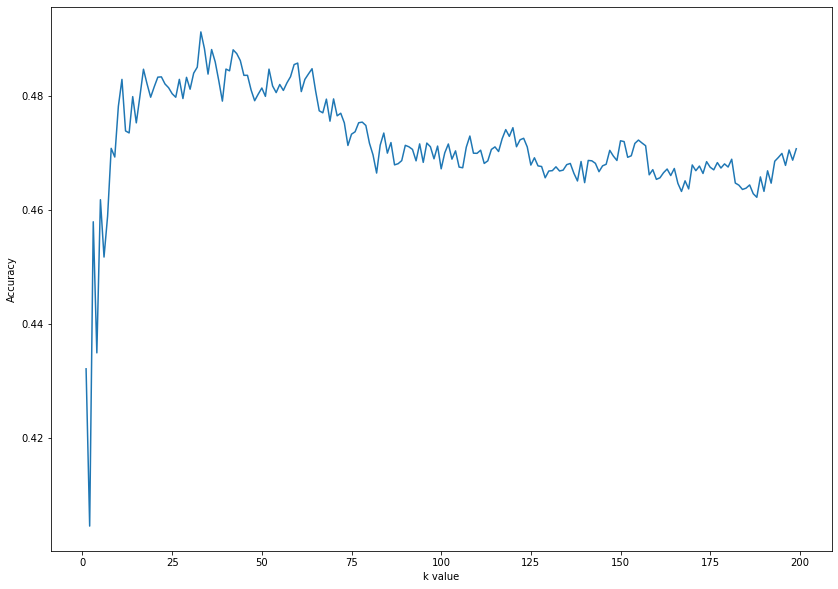

The maximum accuracy has reached in k-value:  33


In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score
from matplotlib import pyplot as plt
scores = []
for x in range(1,200):
    classifier = KNeighborsClassifier(n_neighbors = x)
    classifier.fit(features_train, labels_train.ravel())
    y_iter = classifier.predict(features_val)
    scores.append(f1_score(labels_val, y_iter, average='macro'))
plt.figure(figsize=(14,10))
plt.plot(range(1,200), scores)
plt.ylabel('Accuracy')
plt.xlabel('k value')
plt.show()

print("The maximum accuracy has reached in k-value: ", scores.index(max(scores))+1)

In [19]:
classifier = KNeighborsClassifier(n_neighbors=33, metric='euclidean')
classifier.fit(features_train, labels_train)

y_pred = classifier.predict(features_val)
#Checking performance our model with classification report.
print(classification_report(labels_val, y_pred))


F1_model = f1_score(labels_val, y_pred, average='weighted')
print("The model has a (weighted) F1 score of", round(F1_model, 3),", ", round(((F1_model/F1_baseline)-1) * 100), "% better than the baseline.")



              precision    recall  f1-score   support

           A       0.42      0.40      0.41       597
           B       0.39      0.34      0.36       552
           C       0.52      0.55      0.54       580
           D       0.63      0.69      0.66       692

    accuracy                           0.51      2421
   macro avg       0.49      0.49      0.49      2421
weighted avg       0.50      0.51      0.50      2421

The model has a (weighted) F1 score of 0.5 ,  101 % better than the baseline.


# Evaluation
## Running on test set

After we're satisfied with the model, we run it on test set we've separated earlier, and try to analyze whether the ground truth differs greatly from the predicted values.

In [20]:
y_pred_test = classifier.predict(features_test)
results_df = pd.concat([pd.Series(labels_test).rename('ground truth'), pd.Series(y_pred_test).rename('predicted')], axis=1)
is_error = lambda row: True if row['predicted'] == row['ground truth'] else False

results_df['result'] = results_df.apply(is_error, axis=1)
results_df


,ground truth,predicted,result
0,B,A,False
1,A,B,False
2,A,A,True
3,B,C,False
4,A,A,True
...,...,...,...
2622,B,C,False
2623,A,A,True
2624,C,A,False
2625,C,A,False


In [21]:
results_df['result'].value_counts().rename_axis('unique_values').to_frame('counts')

,counts
unique_values,
False,1869
True,758


## Conclusion

In the end, the classifier we made ended up only being able to predict **758** true classes out of a total of 2627 examples. This is relatively low. Yet again, this is pretty much to be expected since we didn't implement hyperparameter tuning at all via `GridSearchCV`. We also stick to the `euclidean` distance as opposed to the default `minkowski` given by the class.